In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import ast

In [2]:
prices = pd.read_json('stock_prices.json')
sentiments = pd.read_json('aligned_sentiments.json')

indices = []

for item in prices.columns.values:
    indices.append(ast.literal_eval(item))
    
prices.columns = pd.MultiIndex.from_tuples(indices)

indices = []

for item in sentiments.columns.values:
    indices.append(ast.literal_eval(item))
    
sentiments.columns = pd.MultiIndex.from_tuples(indices)

In [11]:
prices.swaplevel(axis=1)['NFLX']

,Adj Close,Close,High,Low,Open,Volume
2018-01-02,201.070007,201.070007,201.649994,195.419998,196.100006,10966900
2018-01-03,205.050003,205.050003,206.210007,201.500000,202.050003,8591400
2018-01-04,205.630005,205.630005,207.050003,204.000000,206.199997,6029600
2018-01-05,209.990005,209.990005,210.020004,205.589996,207.250000,7033200
2018-01-08,212.050003,212.050003,212.500000,208.440002,210.020004,5580200
...,...,...,...,...,...,...
2021-08-03,510.820007,510.820007,515.630005,505.369995,514.390015,2579400
2021-08-04,517.349976,517.349976,517.979980,510.369995,513.000000,2039400
2021-08-05,524.890015,524.890015,525.409973,514.020020,517.130005,2556700
2021-08-06,520.549988,520.549988,526.840027,519.390015,524.000000,1919400


In [13]:
prices = prices['Adj Close']
bert_body = sentiments['bert_body']
missing_prices = list(prices.isna().sum()[prices.isna().sum() != 0].index)
missing_prices.remove('OGN')


prices.drop(columns=missing_prices, inplace=True)
bert_body.drop(columns=missing_prices, inplace=True)

/home/jradhima/miniconda3/envs/thesis/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
set(bert_body.columns).intersection(set(missing_prices))

set()

In [15]:
set(prices.columns).intersection(set(missing_prices))

set()

In [16]:
largest_n = bert_body.apply(lambda x: pd.Series(x.nlargest(20).index), axis=1)
smallest_n = bert_body.apply(lambda x: pd.Series(x.nsmallest(20).index), axis=1)

In [17]:
days = len(largest_n.index)
holding_days = 1
n = 1
capital = 1000000
positions = {}
final_capital = 0
long_amounts = []
short_amounts = []

for day in range(days):
    if day % 100 == 0:
        print(day)
    if day < holding_days:
        best = largest_n.iloc[day, :n].values
        worst = smallest_n.iloc[day, :n].values
        amount = capital / (2 * holding_days * n)
        long_amounts.append(amount)
        short_amounts.append(amount)
        long_positions = [(company, amount / prices.iloc[day][company]) for company in best]
        short_positions = [(company, amount / prices.iloc[day + holding_days][company]) for company in worst]
        positions[day] = {'long': long_positions, 'short': short_positions}
    else:
        days_long = sum([shares * prices.iloc[day][company] 
                          for company, shares in positions[day - holding_days]['long']])
        days_short = sum([shares * prices.iloc[day - holding_days][company] 
                          for company, shares in positions[day - holding_days]['short']])
        long_amounts.append(days_long/n)
        short_amounts.append(days_short/n)
        if days - day <= holding_days:
            final_capital += days_long + days_short
        else:
            best = largest_n.iloc[day, :n].values
            worst = smallest_n.iloc[day, :n].values
            amount = (days_long + days_short) / (2 * n)
            long_positions = [(company, amount / prices.iloc[day][company]) for company in best]
            short_positions = [(company, amount / prices.iloc[day + holding_days][company]) for company in worst]
            positions[day] = {'long': long_positions, 'short': short_positions}
final_capital / capital

0
100
200
300
400
500
600
700


30.676219049559176

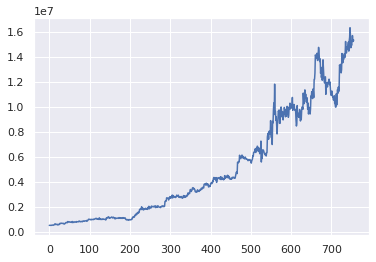

In [18]:
plt.plot(long_amounts)

<AxesSubplot:>

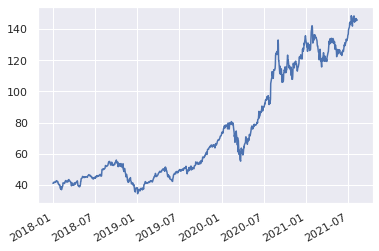

In [19]:
prices['AAPL'].plot()

In [22]:
def trading_algorithm(days, holding_days, n_shares):
    positions = {}
    capital = 1000000
    final_capital = 0
    long_amounts = []
    short_amounts = []
    
    for day in range(days):
        if day % 100 == 0:
            print('Day ',day)
        if day < holding_days:
            best = largest_n.iloc[day, :n_shares].values
            worst = smallest_n.iloc[day, :n_shares].values
            amount = capital / (2 * holding_days * n_shares)
            long_amounts.append(amount)
            short_amounts.append(amount)
            long_positions = [(company, amount / prices.iloc[day][company]) for company in best]
            short_positions = [(company, amount / prices.iloc[day + holding_days][company]) for company in worst]
            positions[day] = {'long': long_positions, 'short': short_positions}
        else:
            days_long = sum([shares * prices.iloc[day][company] 
                              for company, shares in positions[day - holding_days]['long']])
            days_short = sum([shares * prices.iloc[day - holding_days][company] 
                              for company, shares in positions[day - holding_days]['short']])
            long_amounts.append(days_long / n_shares)
            short_amounts.append(days_short / n_shares)
            if days - day <= holding_days:
                final_capital += days_long + days_short
            else:
                best = largest_n.iloc[day, :n_shares].values
                worst = smallest_n.iloc[day, :n_shares].values
                amount = (days_long + days_short) / (2 * n_shares)
                long_positions = [(company, amount / prices.iloc[day][company]) for company in best]
                short_positions = [(company, amount / prices.iloc[day + holding_days][company]) for company in worst]
                positions[day] = {'long': long_positions, 'short': short_positions}
    return final_capital/capital, positions, long_amounts, short_amounts

In [34]:
#len(largest_n.index)
ratio, positions, long, short = trading_algorithm(days=100, holding_days=1, n_shares=1)
ratio

Day  0


1.9489847416305763

In [ ]:
#check why return skyrockets for 1 holding day